In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Projekat 2

**Rok za predaju je 07.06.2024 do kraja dana. Projekti se predaju preko github classroom sistema: [link](https://classroom.github.com/a/x_OQbdg_)** .

Napomene:
- U projektu je potrebno da se nalaze:
  - .ipynb fajl sa analizom
  - README.md fajl u kojm navesti:
    - Imena studenata
    - Da li je su urađene sve tačke, i ako nisu šta nije urađeno
    - Da li je i na koji način korišćena pomoć AI alata  
    (što je dozvoljeno, ali se od studenata očekuje da razumeju i mogu da objasne sve što su dobili kao odgovor)
  - Nije potrebno uploadovati podakte (vcf fajl)
- U .ipynb fajlu, prilikom dodavanja na git:
  - Ćelije koje sadrže grafikone, tabele i druge ispise rezultata ostaviti izvršene (tako da se vide rezultati)
  - Ćelije koje služe za instalaciju alata i biblioteka očistiti
  - Ćelije koje sadrže (duže) ispise alata očistiti


# Postavka

Dati su FASTQ fajlovi koji su rezultat sekvenciranja dela exoma koji se nalazi na hromozomu 11 (podaci su uzeti iz uzoraka 1000 Genomes projekta).

Projekat je moguće raditi pojedinačno ili u paru. Ukoliko se projekat radi u paru, svako treba da obradi podatke iz dodeljenog eksperimenta koji, a rad u paru se odnosi na programski kod i šablon za tekstualni izveštaj.

# 1. [2 boda]
Izvršiti kontrolu kvaliteta FASTQ fajlova alatom FastQC. Priložiti .izvrštaj i diskutovati rezultate (da li je neki od kriterijuma koje analizira FastQC označen kao problematičan, i šta taj kriterijum znači?)

In [ ]:
!apt-get install fastqc

In [ ]:
!fastqc /content/drive/MyDrive/sample_21.chrom11.exome.pe1.fq

In [ ]:
!fastqc /content/drive/MyDrive/sample_21.chrom11.exome.pe2.fq

Označeni su delovi: *per base sequence content*, *per sequence GC content* i *sequence length distribution*

**per base sequence content**

Ovaj modul izučava proporcije svih nukleotida (A, C, G, T) na pozicijama koje isčitava. Idealno, proporcije svake baze bi trebalo da su manje-više konstantne.

**per sequence GC content**

Ovaj modul računa raspoodelu GC parova na svim čitanjima. Idealno, raspodela bi trebalo da bude približna normalnoj.

**sequence length distribution**

Ovaj modul prikazuje raspodelu očitanih dužina u podacima. Idealno, očitavanja bi bila uniformno raspoređena sa jednim vrhom.

# 2. [3 boda]
Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:

 2a. Koliko je readova uspešno mapirano?

 2b. Koliko je parova readova mapirano tako da su oba para mapirana?

 2c. Nacrtati histogram dužina sekvenciranih fragmenata (*template_length*).

In [ ]:
!apt-get update
!apt-get install -y bwa
!apt-get install -y samtools
!mkdir -p bwa_mapping
%cd bwa_mapping
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/GRCh38.primary_assembly.genome.fa.gz
!gunzip GRCh38.primary_assembly.genome.fa.gz
!samtools faidx GRCh38.primary_assembly.genome.fa chr11 > chr11.fa
!bwa index chr11.fa

In [ ]:
!bwa mem chr11.fa /content/drive/MyDrive/sample_21.chrom11.exome.pe1.fq /content/drive/MyDrive/sample_21.chrom11.exome.pe2.fq > mapped_reads_chr11.sam

In [ ]:
!samtools view -b -o mapped_reads_chr11.bam mapped_reads_chr11.sam
!samtools sort -o mapped_reads_chr11.sorted.bam mapped_reads_chr11.bam
!samtools index mapped_reads_chr11.sorted.bam

In [ ]:
!pip install pysam

In [9]:
import pysam
mapped_reads = sum(read.is_mapped for read in pysam.AlignmentFile('mapped_reads_chr11.sorted.bam'))

print("Broj uspešno mapiranih redova:", mapped_reads)

Broj uspešno mapiranih redova: 8883186


In [10]:
import pysam
bam_file = pysam.AlignmentFile('mapped_reads_chr11.sorted.bam', 'rb')
mapped_pairs = sum(1 for read in bam_file if read.is_proper_pair and not read.is_unmapped and not read.mate_is_unmapped)

print("Broj uspešno mapiranih uparenih redova:", mapped_pairs)

Broj uspešno mapiranih uparenih redova: 8803858


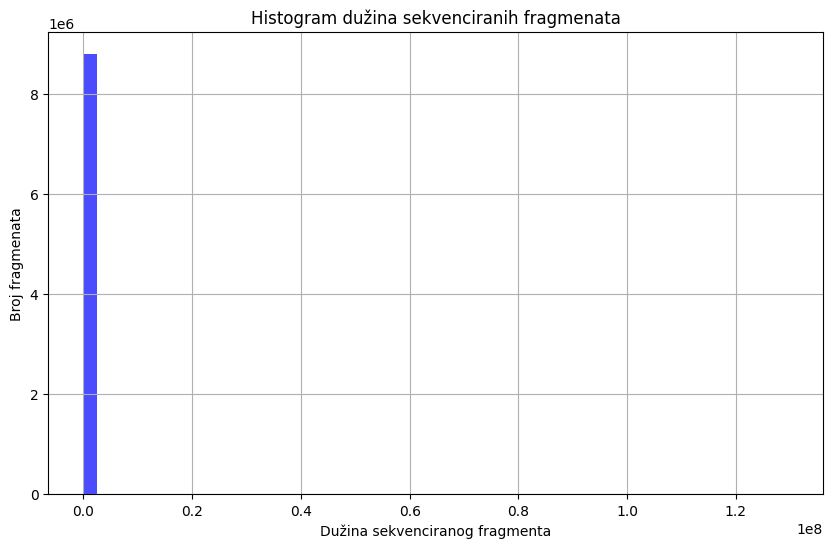

In [11]:
import matplotlib.pyplot as plt

template_lengths = []

with pysam.AlignmentFile('mapped_reads_chr11.sorted.bam', 'rb') as bam:
    for read in bam.fetch():
        if read.is_paired and read.is_proper_pair:

            template_lengths.append(abs(read.template_length))


plt.figure(figsize=(10, 6))
plt.hist(template_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Histogram dužina sekvenciranih fragmenata')
plt.xlabel('Dužina sekvenciranog fragmenta')
plt.ylabel('Broj fragmenata')
plt.grid(True)
plt.show()

# 3. [4 boda]
Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)
3a. Koliki su procenati PCR i optičkih duplikata?

In [ ]:
!pip install crcmod

In [ ]:
### picard
!wget https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

### GATK
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!R -e 'install.packages(c("gplots", "gsalib"))'

In [ ]:
# Instaliranje rpy2 biblioteke
!pip install rpy2

# Uvoz rpy2 modula
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Liste paketa
packnames = ['gplots', 'ggplot2', 'gsalib', 'reshape']

# Instalacija paketa
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

In [15]:
import pysam
i=0
for read in pysam.AlignmentFile('/content/bwa_mapping/mapped_reads_chr11.sorted.bam'):
  if i>100:
    break
  i+=1;
  print(read.qname, read.is_read1, read.tlen, read.pos, read.reference_length, read.is_reverse)

ERR250624.8406470 False 214 60032 100 False
ERR250624.8406470 True -214 60146 100 True
ERR250623.3262607 True 193 60256 100 False
ERR250623.4934491 True 193 60256 100 False
ERR250624.41378762 True 370 60264 100 False
ERR250624.28410089 False 189 60348 100 False
ERR250623.3262607 False -193 60349 100 True
ERR250623.4934491 False -193 60349 100 True
ERR250624.28410089 True -189 60437 100 True
ERR250624.41378762 False -370 60534 100 True
ERR250624.13508378 True 178 60771 100 False
ERR250624.13508378 False -178 60849 100 True
ERR250623.13016372 False 214 61045 100 False
ERR250623.35245762 False 214 61045 100 False
ERR250623.13016372 True -214 61159 100 True
ERR250623.35245762 True -214 61159 100 True
ERR250624.8230006 True 251 61431 100 False
ERR250624.32655961 True 302 61450 87 False
ERR250623.17375768 False 331 61528 100 False
ERR250623.14725881 True 248 61577 100 False
ERR250624.8230006 False -251 61582 100 True
ERR250624.32655961 False -302 61652 100 True
ERR250623.14725881 False -248 

In [ ]:
!gsutil ls gs://genomics-public-data
!gsutil ls gs://genomics-public-data/resources/broad/hg38/v0

In [ ]:
ibam = '/content/bwa_mapping/mapped_reads_chr11.sorted.bam'
obam = '/content/bwa_mapping/mapped_reads_chr11.deduped.bam'

!java -jar ./picard.jar MarkDuplicates I={ibam} O={obam} M=dup_metrics.txt

!grep -A2 '## METRICS CLASS' dup_metrics.txt | grep -v '## METRICS CLASS' > report.tsv

In [18]:
import pandas as pd
pd.read_csv('report.tsv', sep='\t')


,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,Unknown Library,39354,4418351,7130,353230,21250,810258,0,0.184966,10523848


Procenat PCR duplikata = (810258 / 4418351) * 100 ≈ 18.32%

Procenat optičkih duplikata = (0 / 4418351) * 100 = 0%

In [ ]:
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dbsnp138.vcf .
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dbsnp138.vcf.idx .

!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta .
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta.fai .
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict .

In [ ]:
!wget https://storage.googleapis.com/genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dbsnp138.vcf

In [ ]:
gatk = 'java -jar /content/bwa_mapping/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

input_bam = '/content/bwa_mapping/mapped_reads_chr11.deduped.bam'
output_bam = '/content/bwa_mapping/mapped_reads_chr11.with_rg.bam'

!{gatk} AddOrReplaceReadGroups \
    -I {input_bam} \
    -O {output_bam} \
    -RGID 1 \
    -RGLB lib1 \
    -RGPL illumina \
    -RGPU unit1 \
    -RGSM sample

!samtools view -H {output_bam}

In [22]:
ibam = '/content/bwa_mapping/mapped_reads_chr11.with_rg.bam'
obam = '/content/bwa_mapping/mapped_reads_chr11.recalibrated.bam'
recal = '/content/bwa_mapping/mapped_reads_chr11.recal.table'

dbsnp = '/content/bwa_mapping/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/bwa_mapping/Homo_sapiens_assembly38.fasta'

gatk = 'java -jar /content/bwa_mapping/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

In [ ]:
!{gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}

In [ ]:
!{gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}

In [ ]:
post_recal = '/content/bwa_mapping/mapped_reads_chr11.recal.table'
!{gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}

In [ ]:
!{gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots 'compare.pdf'

#4. [4 boda]
Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama).

 4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?

 4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.

 4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

In [ ]:
dbsnp = '/content/bwa_mapping/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/bwa_mapping/Homo_sapiens_assembly38.fasta'

ibam = '/content/bwa_mapping/mapped_reads_chr11.recalibrated.bam'
ovcf = '/content/bwa_mapping/mapped_reads_chr11.vcf'

!{gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

In [28]:
def is_filtered(variant):
  return 'PASS' not in variant.filter

def is_snp(variant):
  return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
  allels = set((variant.ref, variant.alts[0]))
  return allels == {'A', 'G'} or allels == {'C', 'T'}

ti = sum(1 for v in pysam.VariantFile(ovcf) \
         if is_snp(v)\
         and is_transitions(v))

tv = sum(1 for v in pysam.VariantFile(ovcf) \
          if is_snp(v) \
          and not is_transitions(v))

In [29]:
print('Pre filtriranja:')

ovcf = '/content/bwa_mapping/mapped_reads_chr11.vcf'

snp_num = sum(1 for v in pysam.VariantFile(ovcf) if is_snp(v))
indel_num = sum(1 for v in pysam.VariantFile(ovcf) if not is_snp(v))
total_mut = snp_num+indel_num

ti = sum(1 for v in pysam.VariantFile(ovcf) \
         if is_snp(v)\
         and is_transitions(v))

tv = sum(1 for v in pysam.VariantFile(ovcf) \
          if is_snp(v) \
          and not is_transitions(v))

print('Broj mutacija: ', total_mut)
print('\t Od kojih SNP: ', snp_num, 'a INDEL: ', indel_num)

print('Ti/Tv', ti/tv)

Pre filtriranja:
Broj mutacija:  72094
	 Od kojih SNP:  64812 a INDEL:  7282
Ti/Tv 1.9675824175824175


In [30]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0"

ref = '/content/bwa_mapping/Homo_sapiens_assembly38.fasta'

ivcf = '/content/bwa_mapping/mapped_reads_chr11.vcf'
isvcf = '/content/bwa_mapping/mapped_reads_chr11.snp.vcf'
iivcf = '/content/bwa_mapping/mapped_reads_chr11.indel.vcf'

ovcf = '/content/bwa_mapping/mapped_reads_chr11.filtered.vcf'
osvcf = '/content/bwa_mapping/mapped_reads_chr11.snp.filtered.vcf'
oivcf = '/content/bwa_mapping/mapped_reads_chr11.filtered.indel.filtered.vcf'

In [ ]:
!{gatk} SelectVariants -R {ref} -V {ivcf} -O {isvcf} --select-type-to-include SNP
!{gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

!{gatk} SelectVariants -R {ref} -V {ivcf} -O {iivcf} --select-type-to-include INDEL
!{gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

!{gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ovcf}

In [32]:
print('Posle filtriranja:')

ovcf = '/content/bwa_mapping/mapped_reads_chr11.filtered.vcf'

snp_num_f = sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v))
indel_num_f = sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v))
total_filtered = snp_num_f+indel_num_f

ti = sum(1 for v in pysam.VariantFile(ovcf) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tv = sum(1 for v in pysam.VariantFile(ovcf) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Broj mutacija koje nisu prosle filtriranje: ', total_mut-total_filtered)

print('Ti/Tv', ti/tv)

Posle filtriranja:
Broj mutacija koje nisu prosle filtriranje:  71376
Ti/Tv 1.974741623024517


#5. [3 boda]
Anotirati mutacije alatom Funcotator

 5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija *ClinVar_VCF_CLNSIG*, koliko mutacija je označeno kao *Benign*, *Likely_benign*, itd.).

In [ ]:
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download

In [ ]:
!cp "/content/drive/MyDrive/funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz" .
!tar -xzf "funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz"

In [ ]:
ivcf = '/content/bwa_mapping/mapped_reads_chr11.filtered.vcf'
ovcf = '/content/bwa_mapping/mapped_reads_chr11.annoted.vcf'
func = 'funcotator_dataSources.v1.6.20190124g/'

!{gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

In [ ]:
import pysam
ovcf = '/content/bwa_mapping/mapped_reads_chr11.annoted.vcf'

reader = pysam.VariantFile(ovcf)
description = reader.header.info['FUNCOTATION'].description
print(description)
functotations = description[73:].split('|')

In [37]:
import pysam

ovcf = '/content/bwa_mapping/mapped_reads_chr11.annoted.vcf'

clinvar_counts = {}

with open(ovcf, 'r', encoding='utf-8', errors='ignore') as file:
    vcf = pysam.VariantFile(file)
    for variant in vcf:
        try:
            ann = {x:y for x, y in zip(functotations, variant.info['FUNCOTATION'][0][1:-1].split('|'))}
            clinvar_annotation = ann['ClinVar_VCF_CLNSIG']
            if clinvar_annotation in clinvar_counts:
                clinvar_counts[clinvar_annotation] += 1
            else:
                clinvar_counts[clinvar_annotation] = 1
        except Exception as e:
            print("")

print(clinvar_counts)


{'': 71629, 'Benign': 300, 'Uncertain_significance': 10, 'Benign/Likely_benign': 71, 'Likely_benign': 54, 'Conflicting_interpretations_of_pathogenicity': 5, 'not_provided': 6, 'Benign/Likely_benign_%2C__drug_response_%2C__risk_factor': 1, 'Pathogenic': 1, 'association': 6, 'Benign_%2C__risk_factor': 1, 'drug_response': 1, 'risk_factor': 2}


#6. [4 boda]
Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

In [ ]:
!git clone https://github.com/sparsehash/sparsehash.git
!cd sparsehash && ./configure
!cd sparsehash && make
!cd sparsehash && sudo make install

!sudo apt-get install autotools-dev automake
!git clone https://github.com/bcgsc/abyss.git
!cd abyss && ./autogen.sh
!cd abyss && ./configure
!cd abyss && make
!cd abyss && sudo make install

!sudo apt-get install abyss

In [ ]:
%%time
from time import time

In [ ]:
!samtools view -b -f 4 mapped_reads_chr11.sorted.bam > unmapped_reads.bam

!samtools fastq unmapped_reads.bam -1 unmapped_reads_1.fq -2 unmapped_reads_2.fq -0 /dev/null -s /dev/null -n

In [ ]:
!abyss-pe k=64 name=assembly in='unmapped_reads_1.fq unmapped_reads_2.fq'

In [44]:
import pysam

freader = pysam.FastaFile('assembly-contigs.fa')

max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]

longest_scaffold = freader.fetch(max_ref[1])

print(f'Najduži skafold: {max_ref[1]} sa dužinom {max_ref[0]}')
print(f'Sekvenca:\n{longest_scaffold}')

Najduži skafold: 12172 sa dužinom 3220
Sekvenca:
GTTTTCGCTTCATTTAGTTGTGCTTTATAATGTGCTTTAGATGAAGCCGATAACTGTTTTAATTGCTCAATTTGACGAATTGCTTTGTCAACTTTGTCTAATAAATCTTGCTTAGATAATATCTCTTTTGAAATTTCAGTATCCTTTTCAGATGCAGCTTGGGCATCGTACGGCAAGATATTCGTTAAAATGATACTTGTCGCCATCATTGTCGAACACGATAACTTTACATATAATTGAAACGATTTCCCTCGATATTTAGCCATCAACATACTCCTTTCTCACTTACTTCCTTCAAAGAATTACATACTATTATATACCTGTTTACAAGAAATTTACACTTATCTATCTAGTTATTGTTGTTAGTAATTATCCACTTATTACTTAGCTTATATTTAAGTAAACAAAAAAGCATGACGTAATATCATATTGTCCATGTCGCTAACATCATATTACGTCAAATCTTTTATATTAAATGATGTTTTATTTTAGACTGCTTTTTCTTTTTAGCTTTCGAGCGCCTGTTTAAAAACTTGCTCGAATTGTTCACGCGAGATTTCGTGTGCATGTGCTTTTTGTGCTAATAAAGCATCTCGAAACTGTTGTTGATCTTTCAAACTCTCTAACATTTGTATTAATTGGTCTTTACTTTCCATTGTTATCTCATCATTATGCTCAAATAAGTGCTCTGATAATGTTACTTTAGCATGGTGTGCGGTTTGACGATAACCTAAAATCAACAACTCATAGTCAAACGCTTGTTCCACCGCATTTAAAATTTCATTACCCTCATTAATATCAAGATAAATATCACATAACTGGTATAGTTCATTTACCCTATCTATATTAATAGATGGGTATAAGTACACATTAGCATATTGATCAAGTTGAATTAACTTATCAGACATCTCTGTAATAGCAGCGATGTGAAAATTAAAATCTGGTAAAGTT

[Blast](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastn&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome)

Dobijeni rezultat: *Staphylococcus aureus strain UP_274 chromosome, complete genome*